<a href="https://colab.research.google.com/github/mannmoshe/machine-learning/blob/main/Solutions/Week11_Clustering_Methods_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Methods Exercises

***All the cells that start with "MM" written or edited by Moshe Mann.***

## Introduction

We will be using the wine quality data set for these exercises. This data set contains various chemical properties of wine, such as acidity, sugar, pH, and alcohol. It also contains a quality metric (3-9, with highest being better) and a color (red or white). The name of the file is `Wine_Quality_Data`.

We will be using the chemical properties (i.e. everything but quality and color) to cluster the wine. Though this is unsupervised learning, it can be fun to see how our clustering results map onto color and quality.

## Question 1

* Import the data and examine the features. 
* Note which are continuous, categorical, and boolean. 
* How many entries are there for the two colors and range of qualities? 
* Make a histogram plot of the quality for each of the wine colors.

In [6]:
# Import the data

import pandas as pd
import numpy as np

filepath = 'https://raw.githubusercontent.com/mannmoshe/machine-learning/main/Data/Wine_Quality_Data.csv'
data = pd.read_csv(filepath, sep=',')

data.head(4).T

,0,1,2,3
fixed_acidity,7.4,7.8,7.8,11.2
volatile_acidity,0.7,0.88,0.76,0.28
citric_acid,0,0,0.04,0.56
residual_sugar,1.9,2.6,2.3,1.9
chlorides,0.076,0.098,0.092,0.075
free_sulfur_dioxide,11,25,15,17
total_sulfur_dioxide,34,67,54,60
density,0.9978,0.9968,0.997,0.998
pH,3.51,3.2,3.26,3.16
sulphates,0.56,0.68,0.65,0.58


In [7]:
data.shape

(6497, 13)

The data types for each entry. The implementation of K-means in Scikit-learn is designed only to work with continuous data (even though it is sometimes used with categorical or boolean types). Fortunately, all the columns we will be using (everything except quality and color) are continuous.

In [8]:
data.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                    object
dtype: object

The number of entries for each wine color.

In [9]:
data.color.value_counts()

white    4898
red      1599
Name: color, dtype: int64

The distribution of quality values.

In [10]:
data.quality.value_counts().sort_index()

3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: quality, dtype: int64

Now for the histogram.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

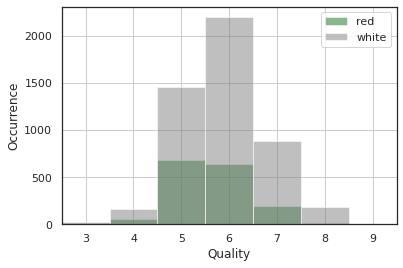

In [12]:
# seaborn styles
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('dark')

# custom colors
red = sns.color_palette()[2]
white = 'gray'

# set bins for histogram
bin_range = np.array([3, 4, 5, 6, 7, 8, 9])

# plot histogram of quality counts for red and white wines
ax = plt.axes()
for color, plot_color in zip(['red', 'white'], [red, white]):
    q_data = data.loc[data.color==color, 'quality']
    q_data.hist(bins=bin_range, 
                alpha=0.5, ax=ax, 
                color=plot_color, label=color)
    

ax.legend()
ax.set(xlabel='Quality', ylabel='Occurrence')

# force tick labels to be in middle of region
ax.set_xlim(3,10)
ax.set_xticks(bin_range+0.5)
ax.set_xticklabels(bin_range);
ax.grid('off')


## Question 2

* Example the correlation and skew of the relevant variables--everything except color and quality.
* Perform any appropriate feature transformations and/or scaling.
* Examine the pairwise distribution of the variables with pairplots to verify scaling and normalization efforts.


In [13]:
float_columns = [x for x in data.columns if x not in ['color', 'quality']]

# The correlation matrix
corr_mat = data[float_columns].corr()

# Strip out the diagonal values for the next step
for x in range(len(float_columns)):
    corr_mat.iloc[x,x] = 0.0
    
corr_mat

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
fixed_acidity,0.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452
volatile_acidity,0.219008,0.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640
citric_acid,0.324436,-0.377981,0.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493
residual_sugar,-0.111981,-0.196011,0.142451,0.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415
chlorides,0.298195,0.377124,0.038998,-0.128940,0.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916
free_sulfur_dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,0.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838
total_sulfur_dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,0.000000,0.032395,-0.238413,-0.275727,-0.265740
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,0.000000,0.011686,0.259478,-0.686745
pH,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,0.000000,0.192123,0.121248
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,0.000000,-0.003029


In [14]:
# Pairwise maximal correlations
corr_mat.abs().idxmax()

fixed_acidity                        density
volatile_acidity        total_sulfur_dioxide
citric_acid                 volatile_acidity
residual_sugar                       density
chlorides                          sulphates
free_sulfur_dioxide     total_sulfur_dioxide
total_sulfur_dioxide     free_sulfur_dioxide
density                              alcohol
pH                               citric_acid
sulphates                          chlorides
alcohol                              density
dtype: object

And an examination of the skew values in anticipation of transformations.

In [15]:
skew_columns = (data[float_columns]
                .skew()
                .sort_values(ascending=False))

skew_columns = skew_columns.loc[skew_columns > 0.75]
skew_columns

chlorides              5.399828
sulphates              1.797270
fixed_acidity          1.723290
volatile_acidity       1.495097
residual_sugar         1.435404
free_sulfur_dioxide    1.220066
dtype: float64

In [16]:
# Perform log transform on skewed columns
for col in skew_columns.index.tolist():
    data[col] = np.log1p(data[col])


Perform feature scaling.

In [17]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
data[float_columns] = sc.fit_transform(data[float_columns])

data.head(4)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,0.229509,2.135767,-2.192833,-0.815173,0.624554,-1.193601,-1.446359,1.034993,1.813090,0.250355,-0.915464,5,red
1,0.550261,3.012817,-2.192833,-0.498175,1.281999,-0.013944,-0.862469,0.701486,-0.115073,1.059213,-0.580068,5,red
2,0.550261,2.438032,-1.917553,-0.625740,1.104012,-0.754684,-1.092486,0.768188,0.258120,0.862549,-0.580068,5,red
3,2.802728,-0.337109,1.661085,-0.815173,0.594352,-0.574982,-0.986324,1.101694,-0.363868,0.389396,-0.580068,6,red


Finally, the pairplot of the transformed and scaled features.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

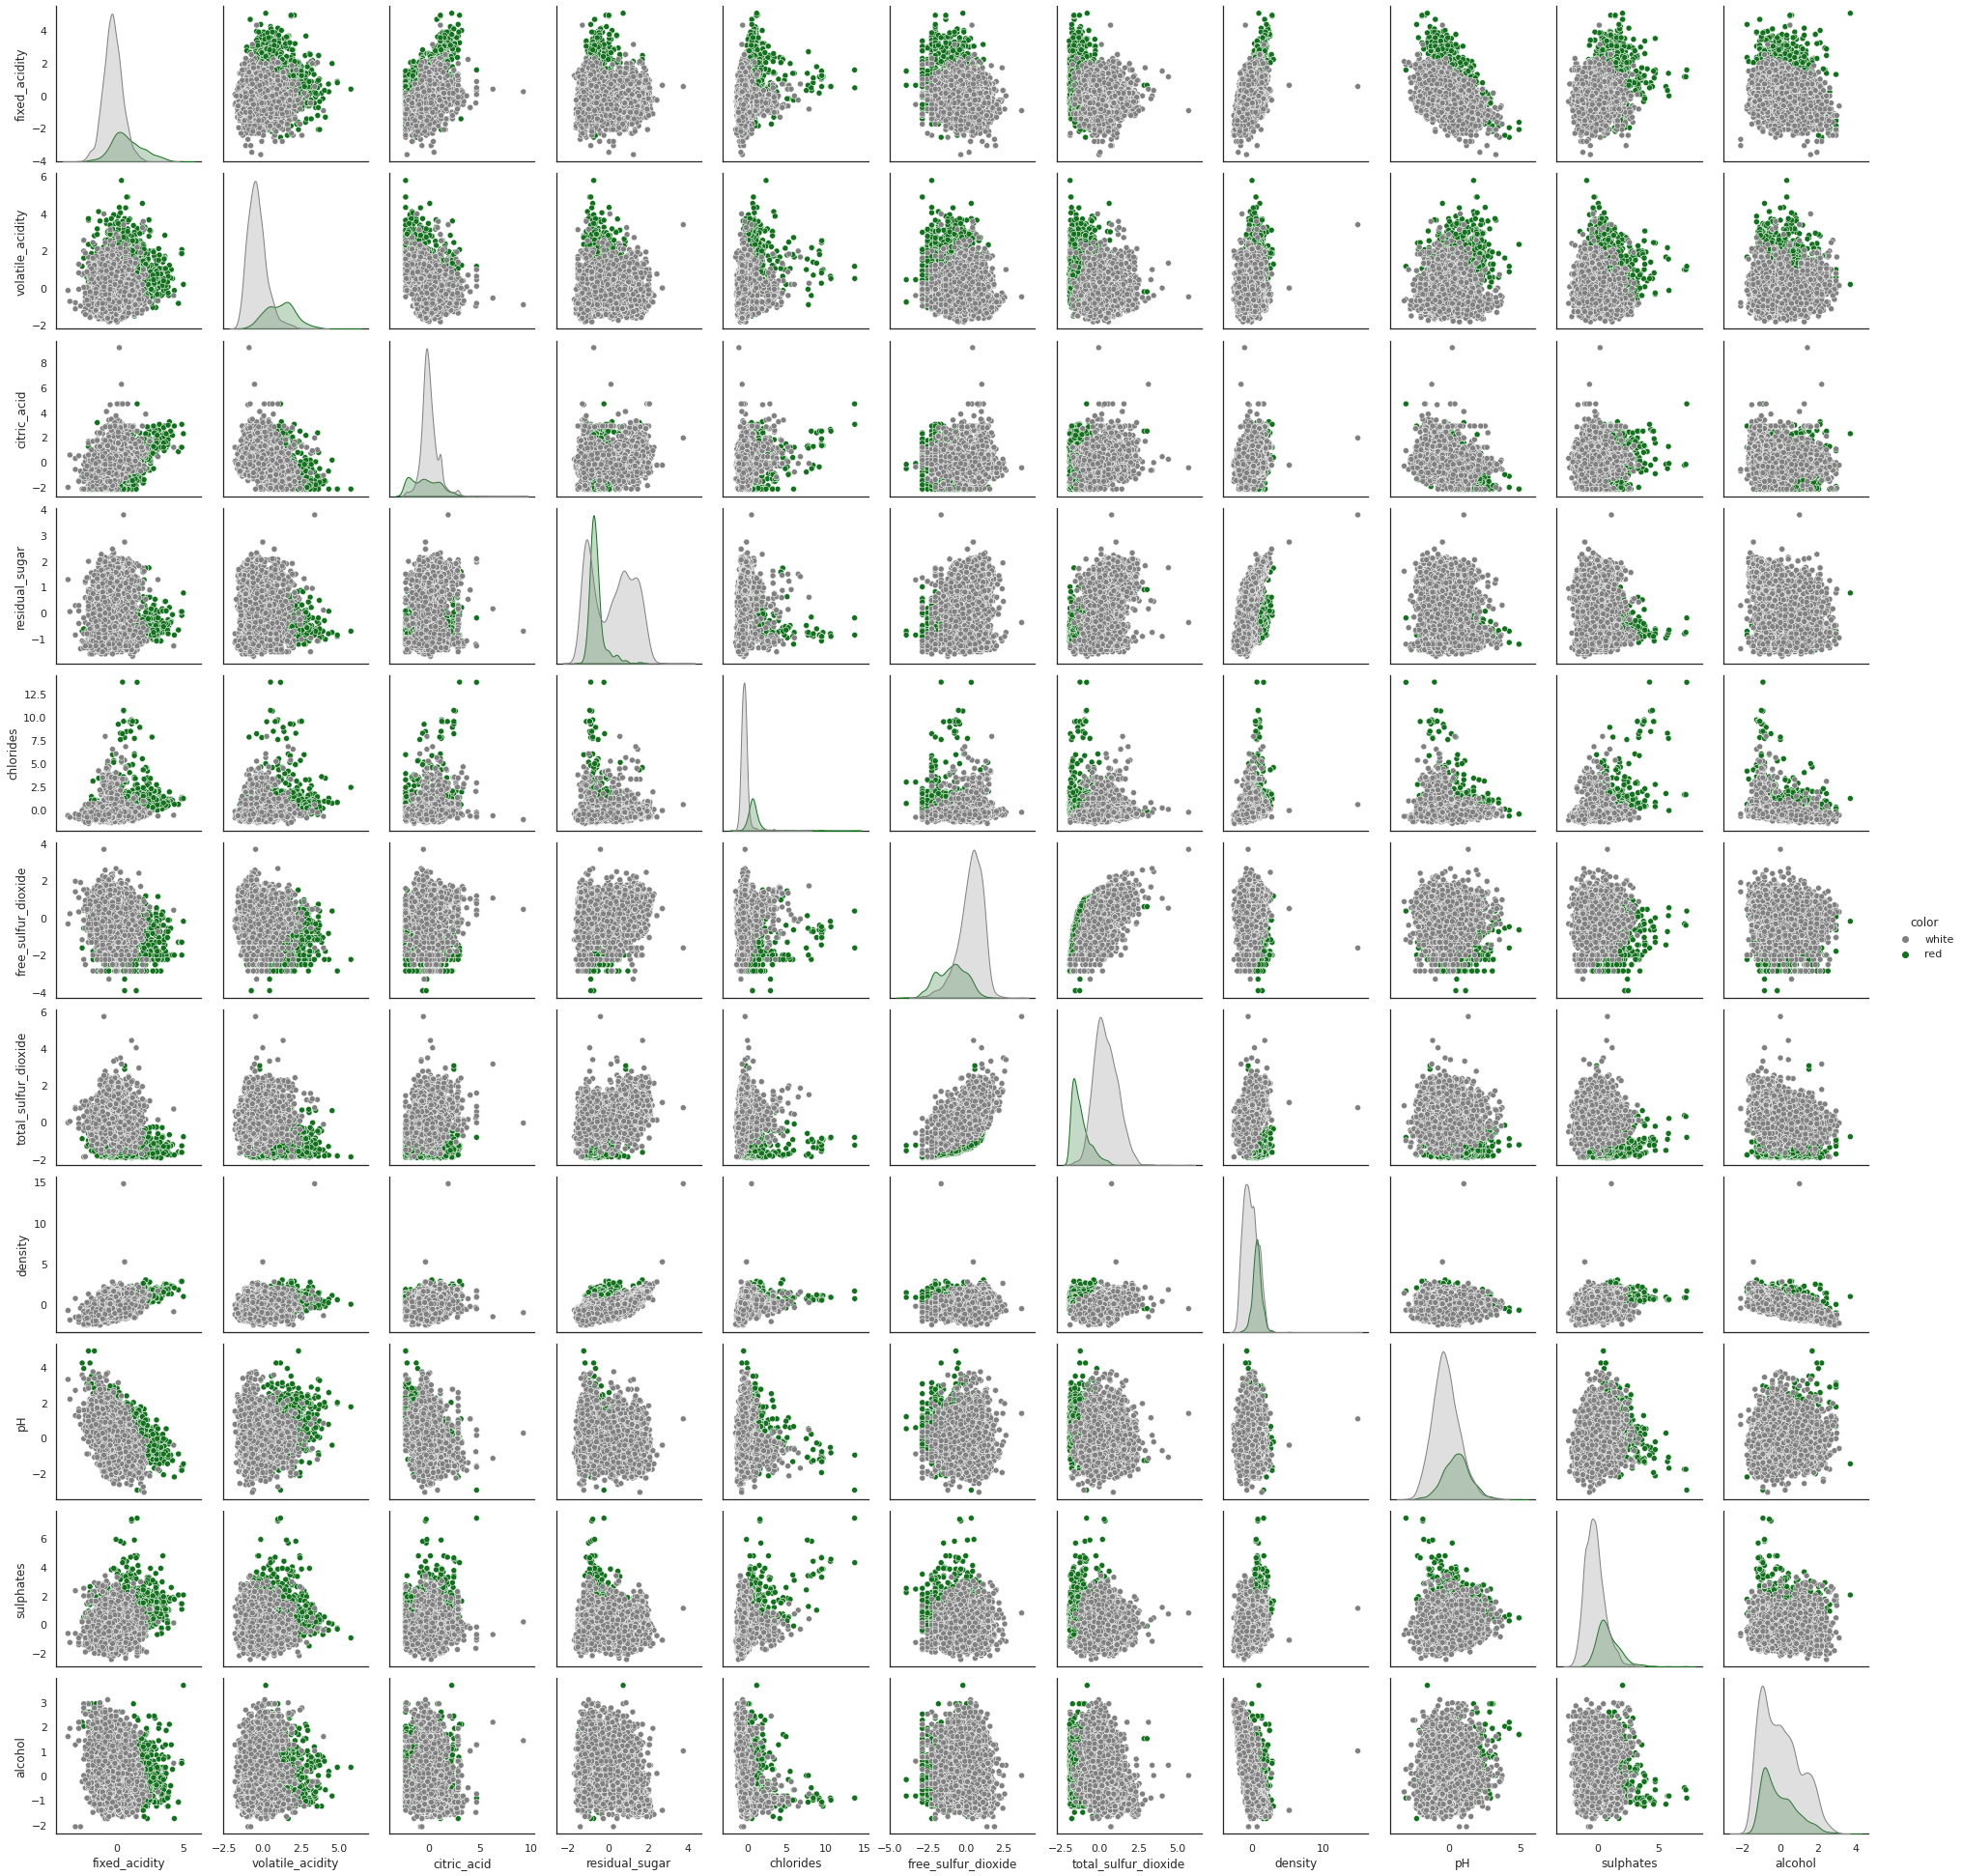

In [18]:
sns.set_context('notebook')
sns.pairplot(data[float_columns + ['color']], 
             hue='color', 
             hue_order=['white', 'red'],
             palette={'red':red, 'white':'gray'});

## Question 3

* Fit a K-means clustering model with two clusters.
* Examine the clusters by wine color.

In [19]:
from sklearn.cluster import KMeans

#from sklearn.cluster import cluster

km = KMeans(n_clusters=2, random_state=42)
km = km.fit(data[float_columns])

data['kmeans'] = km.predict(data[float_columns])

In [20]:
(data[['color','kmeans']]
 .groupby(['color','kmeans'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
color kmeans        
red   0         1576
      1           23
white 0           87
      1         4811

##PCA 2D visualization

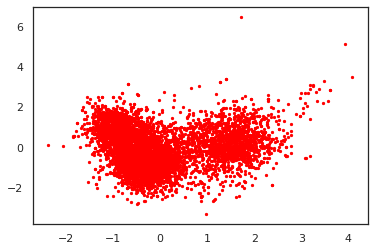

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = data[float_columns]
pca = PCA(n_components=2, whiten=True).fit(X)
X_pca = pca.transform(X) #regular PCA

plt.scatter(X_pca[:,0],X_pca[:,1],c='r',s=5)


#Compare clustered data with PCA projection

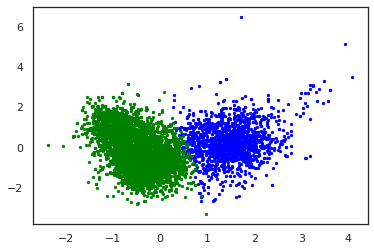

In [22]:
idx = km.predict(data[float_columns])
idx_0 = np.argwhere(idx==0)
idx_1 = np.argwhere(idx==1)
plt.scatter(X_pca[idx_0,0],X_pca[idx_0,1],c='b',s=5)
plt.scatter(X_pca[idx_1,0],X_pca[idx_1,1],c='g',s=5)

#Same, but using TSNE
##PCA is linear dimensionality reduction while TSNE is nonlinear dimensionality reduction (a flavor of manifold learning)

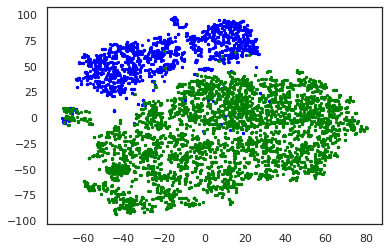

In [23]:
from sklearn.manifold import TSNE

X_TSNE = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
plt.scatter(X_TSNE[idx_0,0],X_TSNE[idx_0,1],c='b',s=5)
plt.scatter(X_TSNE[idx_1,0],X_TSNE[idx_1,1],c='g',s=5)

#Compare pca projection with color

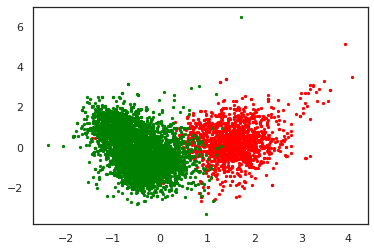

In [24]:
idx_0 = (data.color=='red')
idx_1 = (data.color=='white')
plt.scatter(X_pca[idx_0,0],X_pca[idx_0,1],c='r',s=5)
plt.scatter(X_pca[idx_1,0],X_pca[idx_1,1],c='g',s=5)

## Question 4

* Now fit K-Means models with cluster values ranging from 1 to 20.
* For each model, store the number of clusters and the inertia value. 
* Plot cluster number vs inertia. Does there appear to be an ideal cluster number?

In [25]:
# Create and fit a range of models
km_list = list()

for clust in range(1,20):
    km = KMeans(n_clusters=clust, random_state=42)
    km = km.fit(data[float_columns])
    
    km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km}))

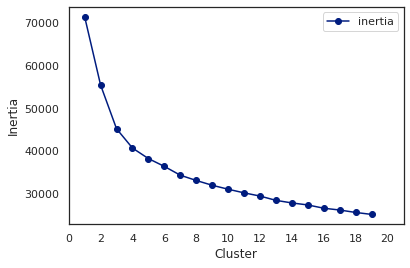

In [26]:
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,21,2))
ax.set_xlim(0,21)
ax.set(xlabel='Cluster', ylabel='Inertia');

## Question 5

* Fit an agglomerative clustering model with two clusters.
* Compare the results to those obtained by K-means with regards to wine color.
* Visualize the dendrogram produced by agglomerative clustering. *Hint:* SciPy has a module called [`cluster.hierarchy`](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html#module-scipy.cluster.hierarchy) that contains the `linkage` and `dendrogram` functions required to create the linkage map and plot the resulting dendrogram.

In [27]:
from sklearn.cluster import AgglomerativeClustering

ag = AgglomerativeClustering(n_clusters=2, linkage='ward', compute_full_tree=True)
ag = ag.fit(data[float_columns])
data['agglom'] = ag.fit_predict(data[float_columns])

Note that cluster assignment is arbitrary, the respective primary cluster numbers for red and white may not be identical to the ones below and also may not be the same for both K-means and agglomerative clustering.

In [28]:
(data[['color','agglom','kmeans']]
 .groupby(['color','agglom','kmeans'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
color agglom kmeans        
red   0      0           13
             1           18
      1      0         1563
             1            5
white 0      0           38
             1         4717
      1      0           49
             1           94

Though the cluster numbers are not necessarily identical, the clusters are very consistent within a single wine variety (red or white).

And here is a plot of the dendrogram created from agglomerative clustering.

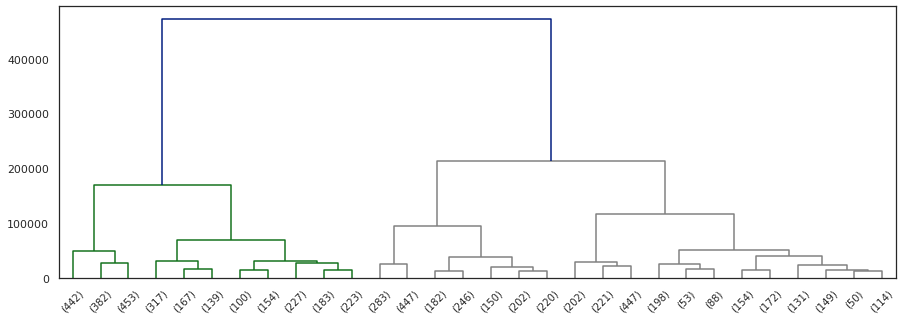

In [29]:
from scipy.cluster import hierarchy
from matplotlib import colors

Z = hierarchy.linkage(ag.children_, method='ward')

fig, ax = plt.subplots(figsize=(15,5))

# Some color customization
dark_palette = sns.color_palette()
red = colors.to_hex(dark_palette[2])
blue = colors.to_hex(dark_palette[0])

hierarchy.set_link_color_palette([red, 'gray'])

den = hierarchy.dendrogram(Z, orientation='top', 
                           p=30, truncate_mode='lastp',
                           show_leaf_counts=True, ax=ax,
                           above_threshold_color=blue)

## Question 6

In this question, we are going to explore clustering as a form of feature engineering.

* Create a **binary** target variable `y`, denoting if the quality is greater than 7 or not.
* Create a variable called `X_with_kmeans` from `data`, by dropping the columns "quality", "color" and "agglom" from the dataset. Create `X_without_kmeans` from that by dropping "kmeans".
* For both datasets, using `StratifiedShuffleSplit` with 10 splits, fit 10 Random Forest Classifiers and average out the roc-auc scores.
* Compare the average roc-auc scores for the models using the kmeans clusters as a feature and the one that doesn't use it.

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit


y = (data['quality'] > 7).astype(int)
X_with_kmeans = data.drop(['agglom', 'color', 'quality'], axis=1)
X_without_kmeans = X_with_kmeans.drop('kmeans', axis=1)
sss = StratifiedShuffleSplit(n_splits=10, random_state=6532)


def get_avg_roc_10splits(estimator, X, y):
    roc_auc_list = []
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        estimator.fit(X_train, y_train)
        y_predicted = estimator.predict(X_test)
        y_scored = estimator.predict_proba(X_test)[:, 1]
        roc_auc_list.append(roc_auc_score(y_test, y_scored))
    return np.mean(roc_auc_list)
# return classification_report(y_test, y_predicted)


estimator = RandomForestClassifier()
roc_with_kmeans = get_avg_roc_10splits(estimator, X_with_kmeans, y)
roc_without_kmeans = get_avg_roc_10splits(estimator, X_without_kmeans, y)
print("Without kmeans cluster as input to Random Forest, roc-auc is \"{0}\"".format(roc_without_kmeans))
print("Using kmeans cluster as input to Random Forest, roc-auc is \"{0}\"".format(roc_with_kmeans))


Without kmeans cluster as input to Random Forest, roc-auc is "0.9048650793650793"
Using kmeans cluster as input to Random Forest, roc-auc is "0.9153888888888888"


Let's now explore if the number of clusters have an effect in this improvement.

* Create the basis training set from `data` by restricting to float_columns.
* For $n = 1, \ldots, 20$, fit a kmeans algotihm with n clusters. One hot encode it and add it to the **basis** training set. Don't add it to the previous iteration.
* Fit 10 **Logistic Regression** models and compute the average roc-auc-score.
* Plot the average roc-auc scores.

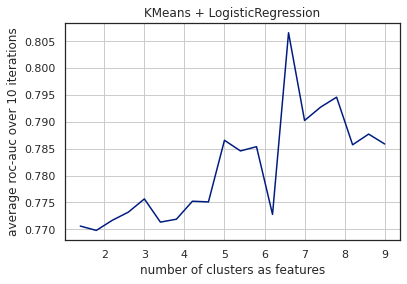

In [31]:
from sklearn.linear_model import LogisticRegression

X_basis = data[float_columns]
sss = StratifiedShuffleSplit(n_splits=10, random_state=6532)


def create_kmeans_columns(n):
    km = KMeans(n_clusters=n)
    km.fit(X_basis)
    km_col = pd.Series(km.predict(X_basis))
    km_cols = pd.get_dummies(km_col, prefix='kmeans_cluster')
    return pd.concat([X_basis, km_cols], axis=1)


estimator = LogisticRegression()
ns = range(1, 21)
roc_auc_list = [get_avg_roc_10splits(estimator, create_kmeans_columns(n), y)
                for n in ns]


# seaborn styles
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('dark')

ax = plt.axes()
ax.plot(ns, roc_auc_list)
ax.set(
    xticklabels= ns,
    xlabel='number of clusters as features',
    ylabel='average roc-auc over 10 iterations',
    title='KMeans + LogisticRegression'
)
ax.grid(True)

## Question 7

Let's now explore on DBSCAN clustering method and if the number of samples have an effect in this improvement.

* Create the basis training set from `data` by restricting to float_columns.
* For $n = 1, \ldots, 20$, fit a kmeans algotihm with n clusters. One hot encode it and add it to the **basis** training set. Don't add it to the previous iteration.
* Fit 10 **Logistic Regression** models and compute the average roc-auc-score.
* Plot the average roc-auc scores.

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN

**MM:** dbscan has no n_clusters parameter.<br>
Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

## Question 8

Let's now explore on Birch clustering method and if the number of clusters have an effect in this improvement.

* Create the basis training set from `data` by restricting to float_columns.
* For $n = 1, \ldots, 20$, fit a kmeans algotihm with n clusters. One hot encode it and add it to the **basis** training set. Don't add it to the previous iteration.
* Fit 10 **Logistic Regression** models and compute the average roc-auc-score.
* Plot the average roc-auc scores.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/

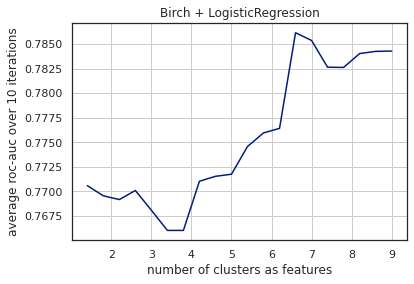

In [34]:
from sklearn.cluster import Birch

X_basis = data[float_columns]
sss = StratifiedShuffleSplit(n_splits=10, random_state=6532)

def create_kmeans_columns(n):
    brc = Birch(n_clusters=n)
    brc.fit(X_basis)
    brc_col = pd.Series(brc.predict(X_basis))
    brc_cols = pd.get_dummies(brc_col, prefix='birch_cluster')
    return pd.concat([X_basis, brc_cols], axis=1)

estimator = LogisticRegression()
ns = range(1, 21)
roc_auc_list = [get_avg_roc_10splits(estimator, create_kmeans_columns(n), y)
                for n in ns]

# seaborn styles
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('dark')

ax = plt.axes()
ax.plot(ns, roc_auc_list)
ax.set(
    xticklabels= ns,
    xlabel='number of clusters as features',
    ylabel='average roc-auc over 10 iterations',
    title='Birch + LogisticRegression'
)
ax.grid(True)